In [584]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pylab as pb
import scipy as sp
from tqdm import tqdm

We start from the Stohastic-Volatility Jump-Diffusion Model, which states that: \
$$ dS(t) = S(t)[(r-\lambda \bar{J})dt + \sqrt{V(t)}dW_s(t) + J(Q)dN(t) \text{ (1)} $$
$$ dV(t) = k(\theta - V(t))dt + \sigma \sqrt{V(t)}dW_v(t) \text{ (2)}$$
$ S(t) $- Stock price at time $t$ \
$ r $- risk-free rate \
$ \lambda $ -jump intensity of the standard Poisson jump counting process $N(t)$ \
$ J(Q) $ - Poisson jump-amplitude that satisfies $ Q = ln(J(Q) + 1) $ \
$ V(t) $ - volatility at time $t$ \
$ W_s(t) $ - Brownian Motion of the Stock at time $t$ \
$ k $ - mean-reversion speed \
$ \theta $ - Long-Term volatility \
$ \sigma $ - volatility scale factor \
$ W_v(t) $ - Brownian Motion of the volatility at time $t$

100%|████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 3768.19it/s]


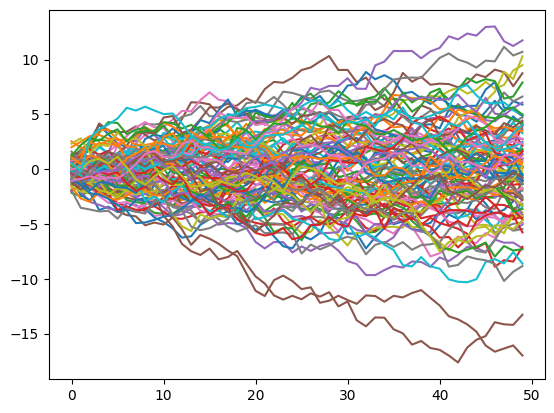

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 30.98it/s]


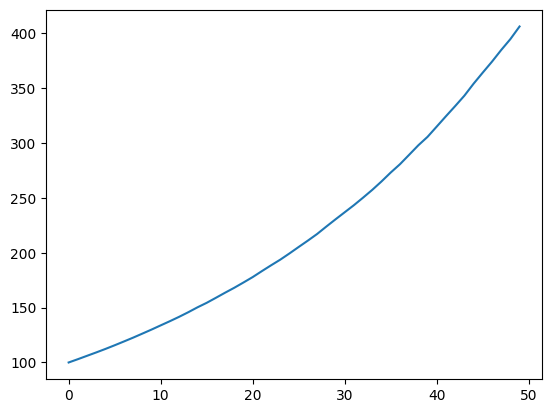

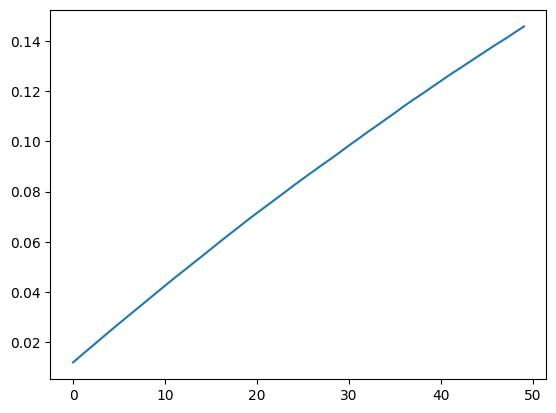

<Figure size 640x480 with 0 Axes>

In [653]:
def SVJDM(S0, r, lambda_, a, b, V0, k, theta, sigma, rho, T=1, paths=10_000):
    assert a<0<b
    steps = int(T * 252 * 2) #The model has proven to be good if the modelling step is between 2 trading hours and 1 trading day 
    dt = T * 252 / steps
    W_s, W_v = (np.random.multivariate_normal([0, 0], [[1, rho], [rho, 1]], (steps, paths))).T
    W_s, W_v = W_s.T , W_v.T
    for t in tqdm(range(1, steps)):
        W_s[t, :], W_v[t, :] = W_s[t-1, :]+ W_s[t, :]*np.sqrt(dt), W_v[t-1, :]+ W_v[t, :]*np.sqrt(dt) 
    plt.plot(W_s[:, :100])
    plt.show()
    plt.clf()
    # dW_s, dW_v = W_s, W_v
    dW_s, dW_v = W_s[1:, :] - W_s[:-1, :], W_v[1:, :] - W_v[:-1, :]
    Q = np.random.uniform(low=a, high=b, size=(steps, paths))
    J = np.exp(Q) - 1 
    S, V = np.zeros((2,steps,paths))
    S[0, :], V[0, :] = S0, V0
    for t in tqdm(range(1, steps)):
        S[t, :] = np.maximum(S[t-1, :]*(1 + (r - lambda_*((np.exp(b)- np.exp(a))/(b-a) - 1)*dt + np.sqrt(V[t-1, :])*dW_s[t-1, :] + np.sum(np.exp(np.random.uniform(low=a, high=b, size=(int(np.ceil(lambda_*dt)), paths)))-1, axis=0))), 0)
        V[t, :] = np.maximum(V[t-1, :] + k*(theta - V[t-1, :])*dt + sigma*np.sqrt(V[t-1, :])*dW_v[t-1, :], 0)
    S, V = S.T[~np.isnan(S.T).any(axis=1)], V.T[~np.isnan(V.T).any(axis=1)]
    S, V = S.T, V.T
    plt.plot(np.mean(S, axis=1))
    plt.show()
    plt.clf()
    plt.plot(np.mean(V, axis=1))
    plt.show()
    plt.clf()
    return S, V
S, V = SVJDM(S0=100, r=.03, lambda_=64, a=-.028, b=.026, V0=.012, k=.012, theta=.53, sigma=.07, rho=-.622, T=.1, paths=50_000)

In [678]:
def kron_delta(i, j):
    if i == j:
        return 1
    else:
        return 0

def beta(r, tau, num):
    return r*tau*kron_delta(num, 2)

def eta(rho, sigma, y, num, k):
    # print('eta', rho*sigma*(1j*y + kron_delta(num, 1)) - k)
    return rho*sigma*(1j*y + kron_delta(num, 1)) - k

def Delta(sigma, y, rho, num, k):
    return np.sqrt(eta(rho, sigma, y, num, k)**2 - sigma**2*1j*y*(1j*y+kron_delta(num, 1) - kron_delta(num, 2)))

def h(tau, sigma, rho, y, k, num):
    # print('delta', Delta(sigma, y, rho, num, k)[-1])
    # print((np.exp(Delta(sigma, y, rho, num, k)*tau)))
    eta_, Delta_ = eta(rho, sigma, y, num, k), Delta(sigma, y, rho, num, k)
    return (eta_**2- Delta_**2)*(np.exp(Delta_*tau) - 1) / (sigma**2*(eta_ + Delta_ - (eta_ - Delta_)*np.exp(Delta_*tau)))

def g(r, lambda_, a, b, y, tau, k, theta, sigma, rho, num):
    J_, kron_delta_, eta_, Delta_ = (np.exp(b)- np.exp(a))/(b-a) - 1, kron_delta(num, 1), eta(rho, sigma, y, num, k), Delta(sigma, y, rho, num, k) 
    non_int_term = ((r-lambda_*J_)*1j*y-lambda_*J_*kron_delta_ - r*kron_delta_)*tau - k*theta/sigma**2*(2*np.log(1- (Delta_ + eta_)*(1-np.exp(-Delta_*tau))/(2*Delta_)) + (Delta_ + eta_)*tau)
    int_term = (np.exp((1j*y+kron_delta_)*b) - np.exp((1j*y+kron_delta_)*a)) / ((b-a)*(1j*y+kron_delta_)) - 1
    # print('DELTA TAU', np.exp(-Delta(sigma, y, rho, num, k)*tau))
    # print('first term', ((r-lambda_*J_)*1j*y-lambda_*J_*kron_delta(num, 1) - r*kron_delta(num, 2))*tau )
    # print('div term', k*theta/sigma**2*(2*np.log(1- (Delta(sigma, y, rho, num, k) + eta(rho, sigma, y, num, k))*(1-np.exp(-Delta(sigma, y, rho, num, k)*tau))/(2*Delta(sigma, y, rho, num, k))) + \
    #         (Delta(sigma, y, rho, num, k) + eta(rho, sigma, y, num, k))*tau))
    # print('int term', int_term)
    return non_int_term + int_term

def f(l, v, t, y, T, r, lambda_, a, b, k, theta, sigma, rho, num):
    # print('g', g(r, lambda_, a, b, y, T-t, k, theta, sigma, rho, num))
    # print('h', h(T-t, sigma, rho, y, k, num))
    # print('beta', beta(r, T-t, num))
    # print(g(r, lambda_, a, b, y, T-t, k, theta, sigma, rho, num) + h(T-t, sigma, rho, y, k, num) + beta(r, T-t, num))
    return np.exp(g(r, lambda_, a, b, y, T-t, k, theta, sigma, rho, num) + h(T-t, sigma, rho, y, k, num)*v + 1j*y*l + beta(r, T-t, num))

def P(l, v, t, kappa, T, r, lambda_, a, b, k, theta, sigma, rho, num, begin=1e-5, end=100): 
    y = np.linspace(begin, end, int((end-begin))) #empirically it was found out that you need to go only up to 1_000 going beyond won't yield meaningful difference
    # print('f', f(l, v, t, y, T, r, lambda_, a, b, k, theta, sigma, rho, num))
    return 1/2 + 1/np.pi*np.trapz(x=y, y=np.real((np.exp(-1j*y*kappa)*f(l, v, t, y, T, r, lambda_, a, b, k, theta, sigma, rho, num)) / (1j*y)))
    
def C_hat(l, v, t, kappa, T, r, lambda_, a, b, k, theta, sigma, rho):
    return np.exp(l)*P(l, v, t, kappa, T, r, lambda_, a, b, k, theta, sigma, rho, 1) - np.exp(kappa-r*(T-t))*P(l, v, t, kappa, T, r, lambda_, a, b, k, theta, sigma, rho, 2)   

In [679]:
T = .1
t_ = 0
t = t_
K = 130
l = np.log(np.mean(S[t_, :]))
kappa = np.log(K)
v = np.mean(V[t_, :])
S0=100
r=.03
lambda_=64
a=-.028
b=.026
V0=.012
k=.012
theta=.53
sigma=.07
rho=-.622

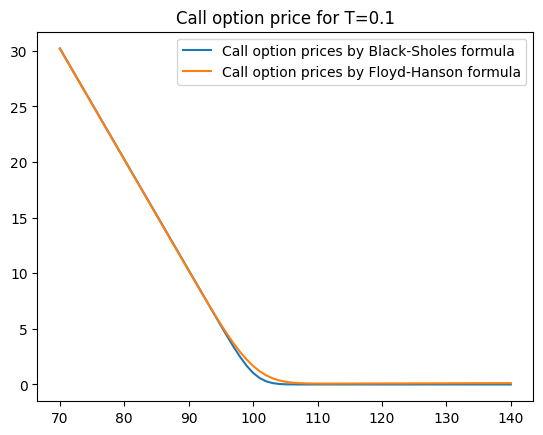

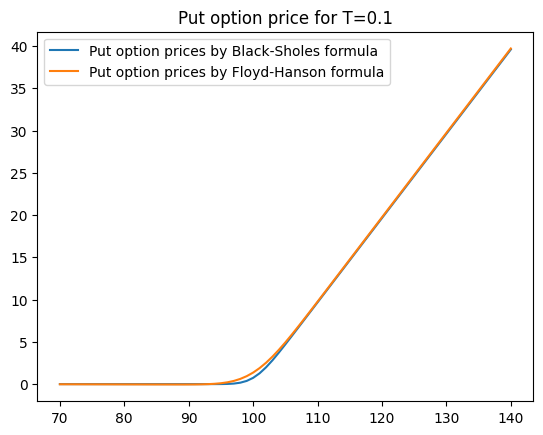

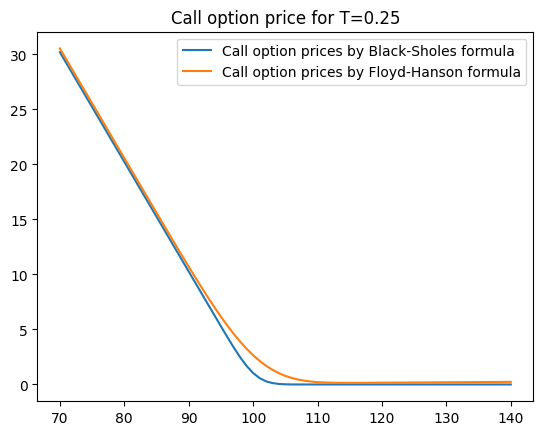

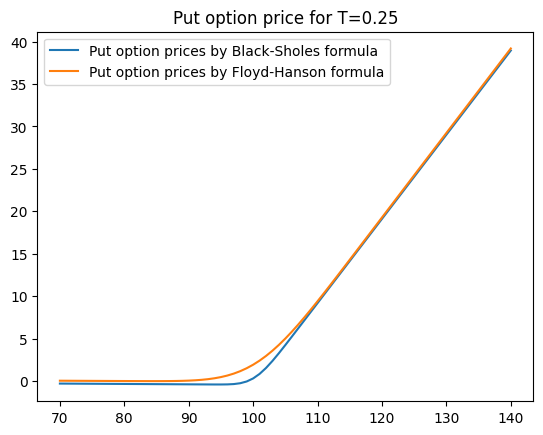

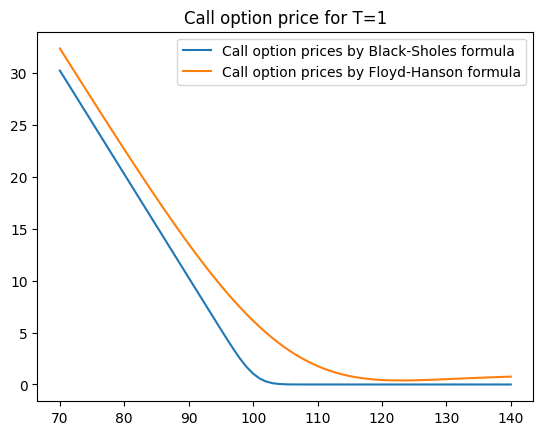

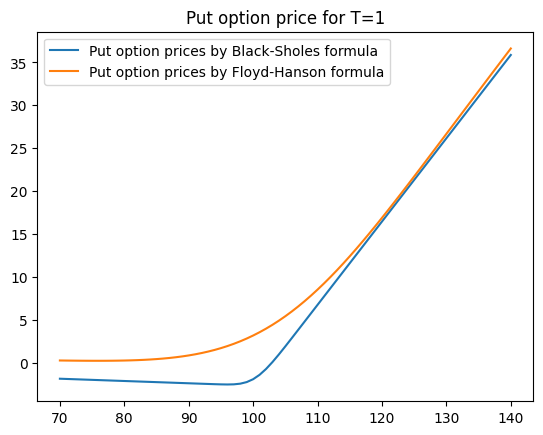

<Figure size 640x480 with 0 Axes>

In [686]:
def BS(S, K, r, sigma, t):
    d1 = (np.log(S/K)+(r+sigma**2/2)*t) / (sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    return S*sp.stats.norm.cdf(d1) - K*np.exp(-r*t)*sp.stats.norm.cdf(d2)

def Put(C, K, S, r, T): #Put option price by put-call parity
    return C + K*np.exp(-r*T) - S



for T in [.1, .25, 1]:
    BS_C_vals = []
    FH_C_vals = []
    for K in range(70, 141):
        BS_C_vals.append(BS(100, K, .03, .07, .1))
        FH_C_vals.append(C_hat(l, v, t, np.log(K), T, r, lambda_, a, b, k, theta, sigma, rho))
    
    plt.plot(list(range(70, 141)), BS_C_vals, label='Call option prices by Black-Sholes formula')
    plt.plot(list(range(70, 141)), FH_C_vals, label='Call option prices by Floyd-Hanson formula')
    plt.title(f"Call option price for T={T}")
    plt.legend()
    plt.show()
    plt.clf()

    BS_C_vals, FH_C_vals = np.array(BS_C_vals), np.array(FH_C_vals)
    BS_P_vals, FH_P_vals = Put(BS_C_vals, np.arange(70, 141), S0, r, T), Put(FH_C_vals, np.arange(70, 141), S0, r, T)
    
    plt.plot(list(range(70, 141)), BS_P_vals, label='Put option prices by Black-Sholes formula')
    plt.plot(list(range(70, 141)), FH_P_vals, label='Put option prices by Floyd-Hanson formula')
    plt.title(f"Put option price for T={T}")
    plt.legend()
    plt.show()
    plt.clf()